In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from tqdm import tqdm
from cartopy import crs as ccrs

from nzdownscale.dataprocess.config_local import DATA_PATHS
from nzdownscale.dataprocess.config import VAR_ERA5, VAR_STATIONS
from nzdownscale.dataprocess import era5, stations, wrf

/home/emily/mambaforge/envs/deepsensor2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
var = 'precipitation'
year = 2020

# Load ERA5

In [4]:
process_era5 = era5.ProcessERA5()
era5_var = VAR_ERA5[var]['var_name']
era5_ds = process_era5.load_ds(var, year)
era5_ds = era5_ds.compute() 

# Load stations

In [5]:
process_stations = stations.ProcessStations()
station_var = VAR_STATIONS[var]['var_name']
station_df = process_stations.load_stations(var, year)

Loading stations:   0%|          | 0/336 [00:00<?, ?it/s]

Filtering stations: 100%|██████████| 237/237 [00:36<00:00,  6.55it/s]


Concatenating stations into pd.DataFrame


In [7]:
station_df

precipitation
time       station_name           latitude  longitude               
2020-01-01 AKAROA EWS             -43.80938 172.96574            0.0
           AKITIO EWS             -40.57728 176.44889            0.0
           ALBERT BURN            -44.38112 168.92633            0.0
           ALEXANDRA AWS          -45.21452 169.37549            0.0
           ALEXANDRA CWS          -45.25366 169.39205            0.0
...                                                              ...
2020-12-31 WHITIANGA AERO AWS     -36.83237 175.67542            0.0
           WHITIANGA EWS          -36.82817 175.67231            0.0
           WINCHMORE 2 EWS        -43.78935 171.79032            0.0
           WINDSOR EWS            -45.00829 170.82281            0.0
           Winchmore 2  Raine EWS -43.78935 171.79032            0.0

[1955425 rows x 1 columns]

# By station

In [9]:
station_df_reset = station_df.reset_index()
station_df_reset['time'] = pd.to_datetime(station_df_reset['time'])
station_df_reset = station_df_reset.set_index('time')

In [10]:
stations = station_df_reset['station_name'].unique()

In [11]:
stats_by_station = {}
for station in tqdm(stations):
    station_data = station_df_reset[station_df_reset['station_name'] == station]
    station_data_vals = station_data[station_var]
    station_sum = station_data_vals.sum()

    era5_data = era5_ds[era5_var].sel(latitude=station_data['latitude'].unique()[0],
                                       longitude=station_data['longitude'].unique()[0],
                                       method='nearest')
    era5_data_vals = era5_data.values
    era5_sum = era5_data_vals.sum()

    stats_by_station[station] = {'station_sum': station_sum, 
                                 'era5_sum': era5_sum,}

  0%|          | 0/233 [00:00<?, ?it/s]

100%|██████████| 233/233 [00:20<00:00, 11.11it/s]


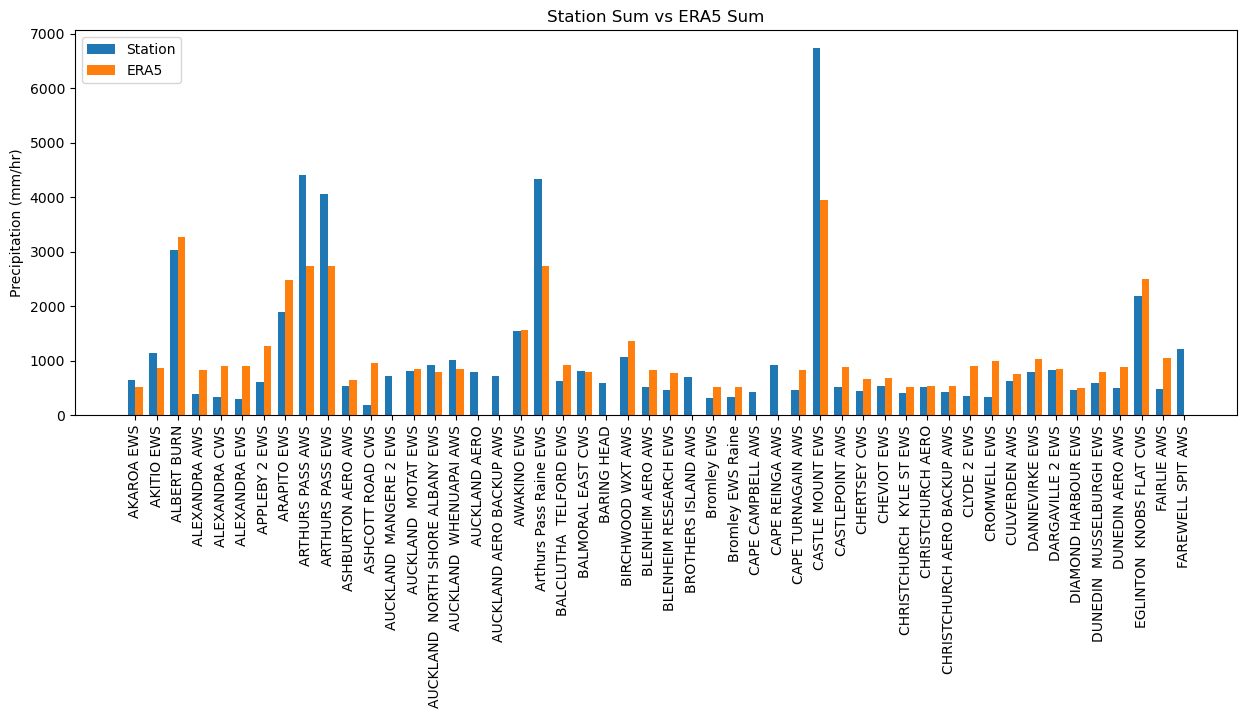

In [12]:
num_stations = len(stats_by_station)

station_names = list(stats_by_station.keys())

station_sums = [stats_by_station[station]['station_sum'] for station in station_names]
era5_sums = [stats_by_station[station]['era5_sum'] for station in station_names]

bar_width = 0.35
bar_positions = np.arange(num_stations)

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the station means and stds
ax.bar((bar_positions - bar_width/2)[:50], station_sums[:50], bar_width, label='Station')
# Plot the era5 means and stds
ax.bar((bar_positions + bar_width/2)[:50], era5_sums[:50], bar_width, label='ERA5')

ax.set_xticks(bar_positions[:50])
ax.set_xticklabels(station_names[:50], rotation=90)

ax.set_ylabel('Precipitation (mm/hr)')
ax.set_title('Station Sum vs ERA5 Sum')
ax.legend()
plt.show();

# Visualise

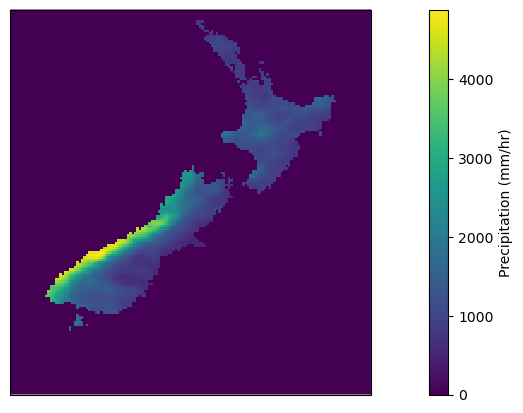

In [14]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
sum_era5 = era5_ds[era5_var].sum(dim='time')
max_era5 = sum_era5.max().values
min_era5 = sum_era5.min().values
sum_era5.plot(ax=ax, 
                cmap='viridis', 
                cbar_kwargs={'label': 'Precipitation (mm/hr)'},
                vmin=min_era5, vmax=max_era5)
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

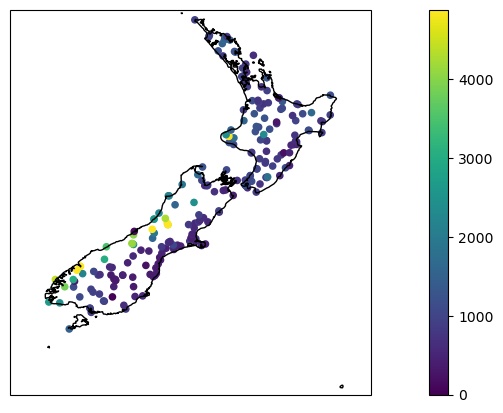

In [16]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
station_sum = station_df.groupby(['latitude', 'longitude']).sum().reset_index()
station_sum.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_sum[station_var], 
                           cmap='viridis',
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)
ax.coastlines()
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

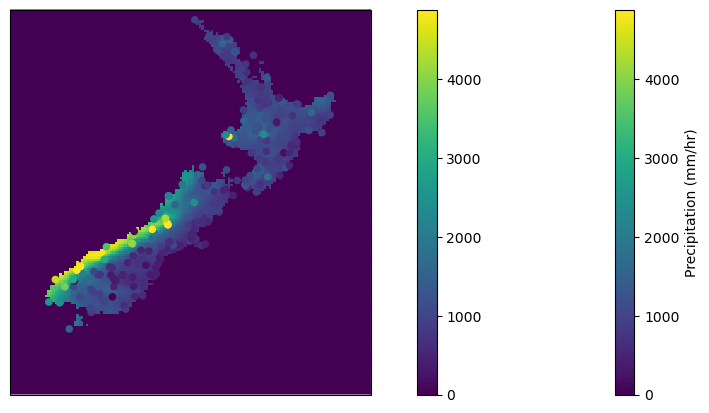

In [17]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})

sum_era5.plot(ax=ax, 
                cmap='viridis', 
                cbar_kwargs={'label': 'Precipitation (mm/hr)'},
                vmin=min_era5, vmax=max_era5)
station_sum.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_sum[station_var], 
                           cmap='viridis',
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)

ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())


In [6]:
from scipy.stats import gamma

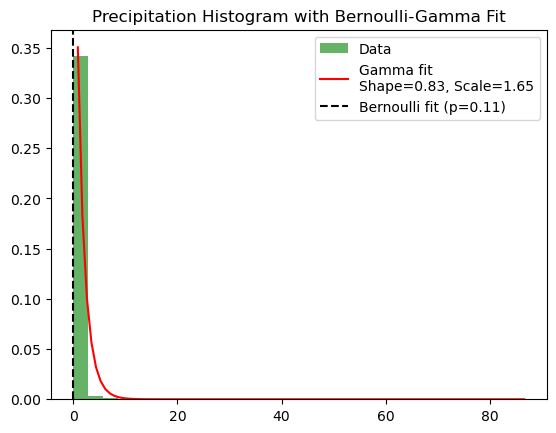

Bernoulli parameter (p) = 0.11
Gamma distribution parameters: Shape = 0.83, Scale = 1.65


In [13]:
precip_data = station_df['precipitation'].values

# Step 1: Fit the Bernoulli distribution
# The probability of rain (p) is the fraction of non-zero precipitation days
rain_days = precip_data > 0  # Binary: 1 for rain, 0 for no rain
p = np.mean(rain_days)  # Probability of rain (Bernoulli parameter)

# Step 2: Fit the Gamma distribution to non-zero precipitation values
nonzero_precip = precip_data[precip_data > 0]
shape, loc, scale = gamma.fit(nonzero_precip, floc=0)  # Fit Gamma distribution

# Generate fitted Gamma PDF for plotting
x = np.linspace(0, max(precip_data), 100)
gamma_pdf = gamma.pdf(x, shape, loc, scale)

# Plot the data and fitted distributions
fig, ax = plt.subplots()
ax.hist(precip_data, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Plot the Gamma distribution fit
ax.plot(x, gamma_pdf, 'r-', label=f'Gamma fit\nShape={shape:.2f}, Scale={scale:.2f}')

# Bernoulli distribution (probability of rain)
ax.axvline(x=0, color='k', linestyle='--', label=f'Bernoulli fit (p={p:.2f})')

# Customize plot
ax.set_title('Precipitation Histogram with Bernoulli-Gamma Fit')
ax.legend()

plt.show()

# Output the Bernoulli and Gamma parameters
print(f"Bernoulli parameter (p) = {p:.2f}")
print(f"Gamma distribution parameters: Shape = {shape:.2f}, Scale = {scale:.2f}")

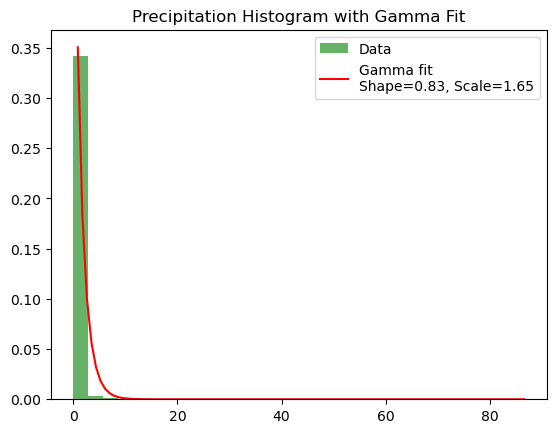

In [18]:
# Just fit non-zero values with gamma
precip_data = station_df['precipitation'].values
nonzero_precip = precip_data[precip_data > 0]
shape, loc, scale = gamma.fit(nonzero_precip, floc=0)  # Fit Gamma distribution

# Generate fitted Gamma PDF for plotting
x = np.linspace(0, max(precip_data), 100)
gamma_pdf = gamma.pdf(x, shape, loc, scale)

# Plot the data and fitted distributions
fig, ax = plt.subplots()
ax.hist(precip_data, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Plot the Gamma distribution fit
ax.plot(x, gamma_pdf, 'r-', label=f'Gamma fit\nShape={shape:.2f}, Scale={scale:.2f}')

# Customize plot
ax.set_title('Precipitation Histogram with Gamma Fit')
ax.legend()

plt.show()